<a href="https://colab.research.google.com/github/theclosedbook/GAN/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing Libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
#Print Tf Version
print(tf.__version__)

2.15.0


In [3]:
## Loading and preprocessing the dataset
(X_train,y_train),(_,_) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
#Shape of X_train
X_train.shape

(60000, 28, 28)

In [5]:
#Shape of y_train
y_train.shape

(60000,)

49479
4


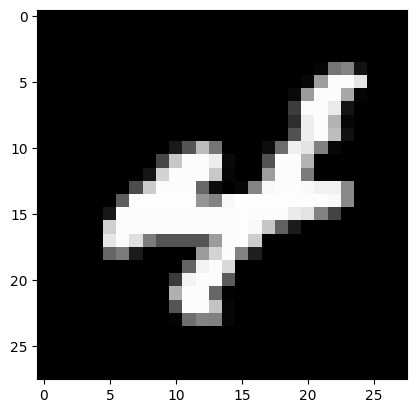

In [6]:
# To Visualize X_train and y_train
i = np.random.randint(0,60000)
print(i)
print(y_train[i])
plt.imshow(X_train[i],cmap='gray')

In [7]:
# Reshaping X_train
X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')

In [8]:
#Shape Of the resized X_train
X_train.shape

(60000, 28, 28, 1)

In [9]:
#Min and Max Value (Normalization Needed)
X_train[0].min(),X_train[0].max()

(0.0, 255.0)

In [10]:
X_train = (X_train - 127.5) / 127.5

In [11]:
X_train[0].min(),X_train[0].max()

(-1.0, 1.0)

In [12]:
buffer_size = 60000
batch_size = 256

In [14]:
#Coneverting from np to tensors
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [16]:
#X_train info after converting into tensor
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>